In [4]:
# pca_full_hand_baseline_off_corrected.py
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from utils import get_hand_mask_548
import os
import numpy as np
import scipy.io as sio
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from utils import get_hand_mask_548
from scipy.ndimage import gaussian_filter
import os


In [ ]:

MAT_PATH = "smarthand_dataset.mat"
MAX_PCS = 200
RANDOM_STATE = 42

def load_full_hand_raw_no_empty():
    print("Loading SmartHand dataset + removing empty_hand...")
    data = sio.loadmat(MAT_PATH)
    
    tactile = data['tactile_data'].astype(np.float32)
    valid   = data['valid_flag'].flatten().astype(bool)
    obj_id  = data['object_id'].flatten().astype(np.int64)
    objects = [''.join(c).strip() for c in data['objects'].flatten()]

    # Find empty_hand class ID
    empty_name = "empty_hand"
    empty_idx = None
    for i, name in enumerate(objects):
        if "empty" in name.lower() and "hand" in name.lower():
            empty_idx = i
            break
    if empty_idx is None:
        raise ValueError("Could not find 'empty_hand' in objects list")

    print(f"Found 'empty_hand' → class ID {empty_idx} ('{objects[empty_idx]}')")

    # Apply valid + exclude empty_hand
    mask = valid & (obj_id != empty_idx)
    tactile = tactile[mask]
    obj_id = obj_id[mask]
    print(f"After removing empty_hand: {tactile.shape[0]:,} frames")

    # Full hand mask → 548 taxels
    hand_mask = get_hand_mask_548()
    X = tactile[:, hand_mask]

    print(f"Final data: X.shape = {X.shape} (frames × taxels)")
    print("Baseline OFF → raw pressure values")
    return X

# ==============================
# RUN
# ==============================
X = load_full_hand_raw_no_empty()

n_comp = min(MAX_PCS, X.shape[1])
pca = PCA(n_components=n_comp, random_state=RANDOM_STATE)
print(f"Fitting PCA on {X.shape[0]:,} samples × {X.shape[1]} features...")
pca.fit(X)

cum_var = np.cumsum(pca.explained_variance_ratio_)

pc_90 = np.searchsorted(cum_var, 0.90) + 1
pc_95 = np.searchsorted(cum_var, 0.95) + 1

print(f"\nPCA RESULTS — Full Hand (548 taxels), Baseline OFF, empty_hand EXCLUDED")
print(f"→ PCs needed for 90% variance: {pc_90}")
print(f"→ PCs needed for 95% variance: {pc_95}")
print(f"→ Reduction @95%: {(1 - pc_95/548)*100:.1f}%")

# Plot
plt.figure(figsize=(10, 6))
x = np.arange(1, len(cum_var)+1)
plt.plot(x, cum_var, 'o-', color='#d62728', lw=2.5, label='Cumulative variance')
plt.axhline(0.90, color='gray', ls=':', lw=1.5)
plt.axhline(0.95, color='gray', ls='--', lw=1.5)
plt.axvline(pc_90, color='gray', ls=':', lw=1.5)
plt.axvline(pc_95, color='gray', ls='--', lw=1.5)

plt.plot(pc_90, cum_var[pc_90-1], 'o', color='black', ms=10)
plt.plot(pc_95, cum_var[pc_95-1], 's', color='black', ms=10)
plt.text(pc_90 + 5, cum_var[pc_90-1], f'{pc_90} PCs → 90%', fontsize=12)
plt.text(pc_95 + 5, cum_var[pc_95-1], f'{pc_95} PCs → 95%', fontsize=12)

plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance Ratio")
plt.title("PCA — Full Hand (548 taxels), Baseline OFF\n(empty_hand class excluded)", 
          fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xlim(1, MAX_PCS)
plt.ylim(0.6, 1.01)
plt.legend()
plt.tight_layout()
plt.show()

In [9]:
# ==============================
# 2. Pearson Taxel Ranking using the PCA scores from above
# ==============================
from sklearn.decomposition import PCA
import pandas as pd
from scipy.ndimage import gaussian_filter

print(f"\nUsing X.shape = {X.shape} (already loaded, empty_hand excluded, full hand)")

# Re-use the PCA we just fitted
pca = PCA(n_components=min(MAX_PCS, X.shape[1]), random_state=RANDOM_STATE)
pca.fit(X)
cum_var = np.cumsum(pca.explained_variance_ratio_)

# Find k for 90% and 95%
k90 = np.searchsorted(cum_var, 0.90) + 1
k95 = np.searchsorted(cum_var, 0.95) + 1
print(f"Using k={k90} PCs for 90% variance ({cum_var[k90-1]*100:.1f}%)")
print(f"Using k={k95} PCs for 95% variance ({cum_var[k95-1]*100:.1f}%)")

# Transform to PCA scores
scores_90 = pca.transform(X)[:, :k90]
scores_95 = pca.transform(X)[:, :k95]

def pearson_rank_taxels(X, scores, keep_idx, agg="maxabs"):
    # Z-score
    Xn = (X - X.mean(axis=0)) / (X.std(axis=0) + 1e-12)
    Zn = (scores - scores.mean(axis=0)) / (scores.std(axis=0) + 1e-12)
    
    # Correlation matrix
    corr = (Xn.T @ Zn) / (len(X) - 1)  # (n_features, k)
    
    if agg == "maxabs":
        score = np.max(np.abs(corr), axis=1)
    elif agg == "sumsq":
        score = np.sum(corr**2, axis=1)
    else:
        raise ValueError("agg must be 'maxabs' or 'sumsq'")
    
    # Build DataFrame
    orig_idx = keep_idx
    row = orig_idx // 32
    col = orig_idx % 32
    
    df = pd.DataFrame({
        "Kept_idx": np.arange(len(keep_idx)),
        "Orig_idx": orig_idx.astype(int),
        "Row": row,
        "Col": col,
        "Score": score
    }).sort_values("Score", ascending=False).reset_index(drop=True)
    
    return df



Using X.shape = (38400, 548) (already loaded, empty_hand excluded, full hand)
Using k=84 PCs for 90% variance (90.0%)
Using k=137 PCs for 95% variance (95.0%)


In [ ]:
# Rank for 90% and 95%
print("\nRanking taxels...")
df_90 = pearson_rank_taxels(X, scores_90, np.where(get_hand_mask_548())[0], agg="maxabs")
df_95 = pearson_rank_taxels(X, scores_95, np.where(get_hand_mask_548())[0], agg="maxabs")

# Save the 95% ranking
df_95.to_csv("res95_ranked_taxels.csv", index=False)
print(f"\nSaved res95_ranked_taxels.csv → {len(df_95)} taxels ranked")



Ranking taxels...

Saved res95_ranked_taxels.csv → 548 taxels ranked


In [11]:
# ==============================
# 3. Visualization Functions
# ==============================
def plot_full_hand_importance(df, title="Taxel Importance (Full Hand)", cmap="hot"):
    imp = np.full(1024, np.nan)
    imp[df["Orig_idx"].values] = df["Score"].values
    imp = imp.reshape(32, 32)
    
    base = np.zeros(1024)
    base[get_hand_mask_548()] = 0.3
    base = base.reshape(32, 32)
    
    plt.figure(figsize=(7,7))
    plt.imshow(base, cmap="Greys", alpha=0.6)
    plt.imshow(imp, cmap=cmap, alpha=0.95)
    plt.colorbar(label="Pearson Importance Score", shrink=0.8)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.axis("off")
    plt.tight_layout()
    plt.show()

def plot_top_n_taxels(df, n, title=None, cmap="hot"):
    top = df.head(n)
    imp = np.full(1024, np.nan)
    imp[top["Orig_idx"].values] = top["Score"].values
    imp = imp.reshape(32, 32)
    
    base = np.zeros(1024)
    base[get_hand_mask_548()] = 0.3
    base = base.reshape(32, 32)
    
    plt.figure(figsize=(7,7))
    plt.imshow(base, cmap="Greys", alpha=0.6)
    plt.imshow(imp, cmap=cmap, alpha=0.95)
    plt.colorbar(label="Score", shrink=0.8)
    plt.title(title or f"Top-{n} Most Important Taxels", fontsize=14, fontweight='bold')
    plt.axis("off")
    plt.tight_layout()
    plt.show()
    
    return top["Orig_idx"].values



Full-hand importance map (95% variance):


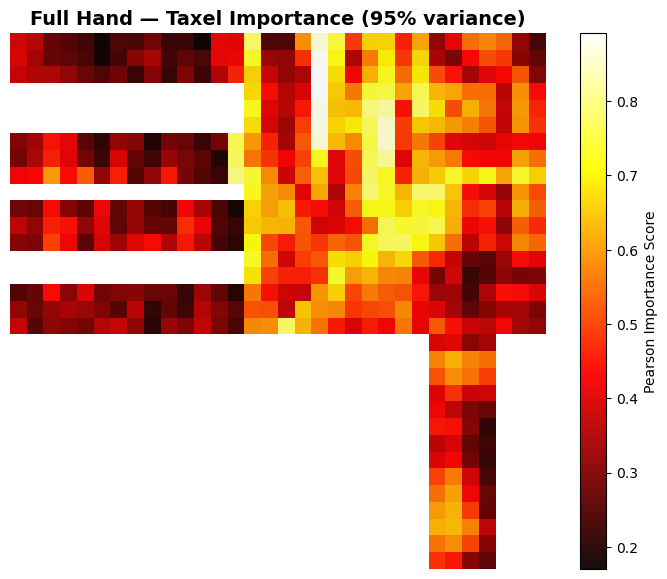

In [ ]:
print("\nFull-hand importance map (95% variance):")
plot_full_hand_importance(df_95, title="Full Hand — Taxel Importance (95% variance)")

Top-N visualizations:


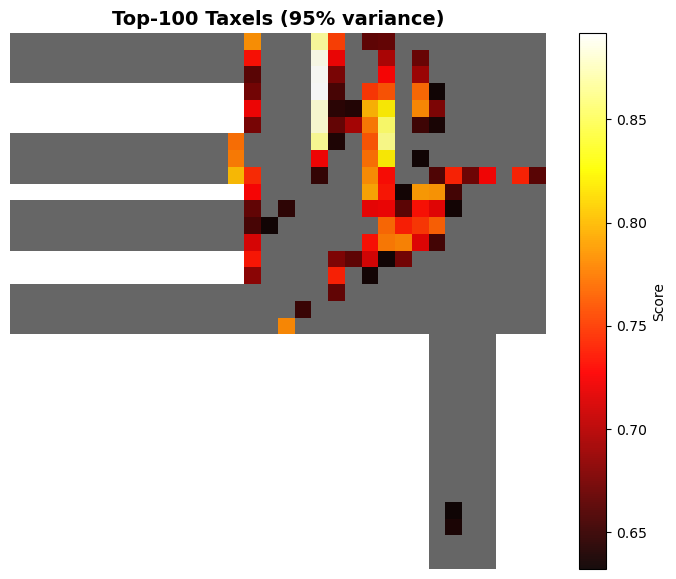

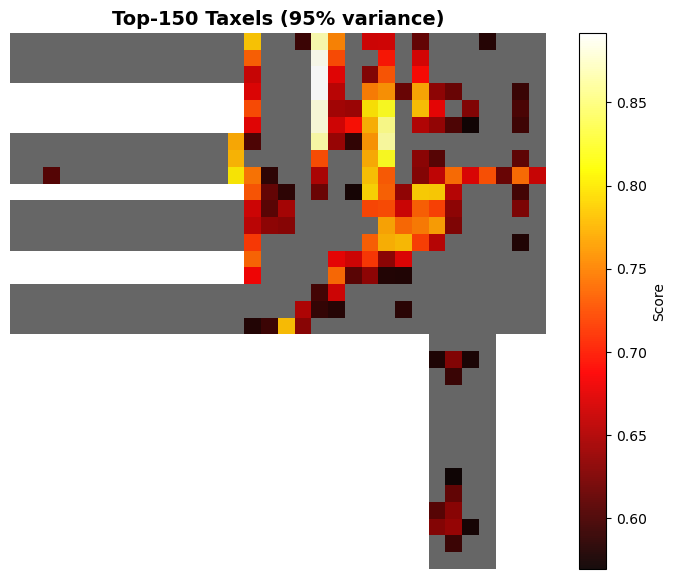

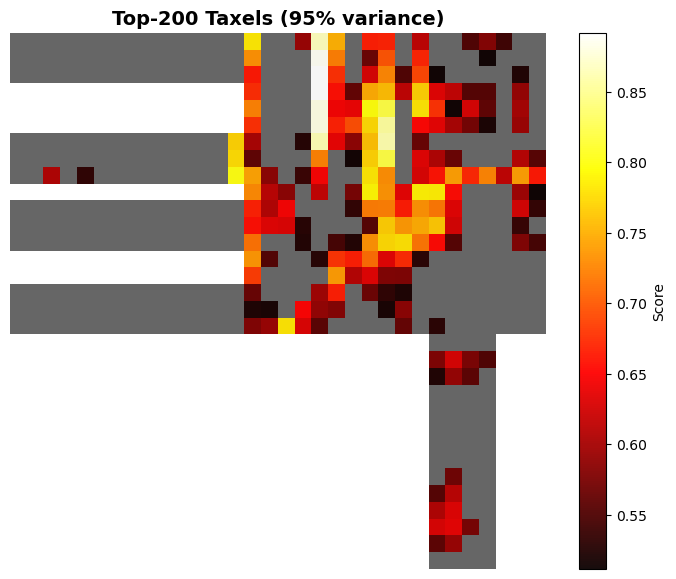

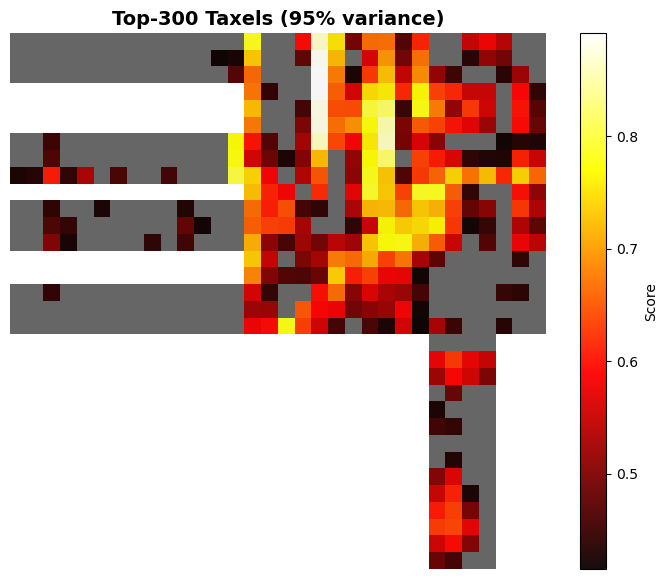


Top 20 most important taxels (95% variance):
[114  82  50 178 146  18 210 214 182 246 150 269 149 309 312 313  14 277
 152 560]


In [13]:
print("Top-N visualizations:")
for n in [100, 150, 200, 300]:
    top_idx = plot_top_n_taxels(df_95, n, title=f"Top-{n} Taxels (95% variance)")

print(f"\nTop 20 most important taxels (95% variance):")
print(df_95.head(20)["Orig_idx"].values)